In [28]:
import random
import os
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact,fixed,FloatSlider,IntSlider,ToggleButtons
import pandas as pd
import datetime
import scipy
from scipy.integrate import odeint
import matplotlib.dates as mdates
import matplotlib
import scipy.stats as st

import math
import xarray as xr
import emcee
import json

from covid19model.optimization import objective_fcns
from covid19model.optimization import MCMC
from covid19model.models import models
from covid19model.data import google
from covid19model.data import sciensano
from covid19model.data import polymod
from covid19model.data import parameters
from covid19model.visualization.output import population_status, infected
from covid19model.visualization.optimization import plot_fit, traceplot

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
initN, Nc_home, Nc_work, Nc_schools, Nc_transport, Nc_leisure, Nc_others, Nc_total = polymod.get_interaction_matrices()
levels = initN.size

In [8]:
# Load the parameters using `get_COVID19_SEIRD_parameters()`.
params = parameters.get_COVID19_SEIRD_parameters()
# Add the delayed ramp parameters to the parameter dictionary.
params.update({'l': 1,
              'tau': 5})
# Define the initial condition: one exposed inidividual in every age category
initial_states = {'S': initN, 'E': np.ones(levels)}
# Load the compliance model
from covid19model.models.compliance import ramp_2
# Initialize the model
model = models.COVID19_SEIRD(initial_states, params, compliance=ramp_2)

In [9]:
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
df_sciensano.tail()

,H_tot,ICU_tot,H_in,H_out,H_tot_cumsum,D_tot,D_25_44,D_45_64,D_65_74,D_75_84,D_85+
DATE,,,,,,,,,,,
2020-08-06,278,65,28,39,687,2,0.0,0.0,0,1.0,1
2020-08-07,285,69,27,28,686,4,0.0,0.0,0,1.0,3
2020-08-08,281,67,31,39,678,2,0.0,0.0,0,2.0,0
2020-08-09,285,69,20,14,684,4,1.0,0.0,0,1.0,2
2020-08-10,312,73,33,12,705,3,0.0,1.0,1,0.0,1


In [10]:
with open('../../data/interim/model_parameters/deterministic_22072020.json', 'r') as fp:
    samples_dict = json.load(fp)

lag_time = samples_dict['lag_time']
model.extraTime = samples_dict['lag_time']

# Check hospitalised

(0, 850)

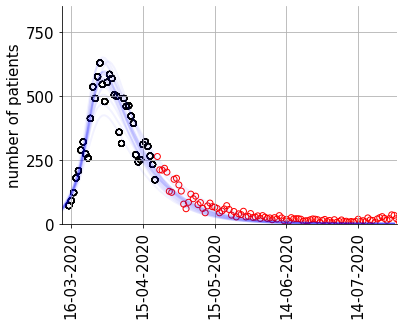

In [17]:
states = [['H_in']]
data = [df_sciensano["H_in"].values[:37]]
T = 100 # extra days to plot model for
end_data = 149#52 end of data tranch to plot
start_date = '15-03-2020'
fig,ax=plt.subplots()
for i in range(20):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time], 
          'Nc':      [prevention*(1.00*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)]
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["H_in"][37:end_data].size)+datetime.timedelta(days=data[0].size),df_sciensano["H_in"][37:end_data], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1,1))
ax.set_ylim([0,850])
#plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

# Check deceased

Sciensano gives the total deceased (including nursery homes), but the model only predicts deceased from the hospital.

In [18]:
df_sciensano['D_cumsum'] = df_sciensano.D_tot.cumsum()

Text(0.5, 1.0, 'Total deceased')

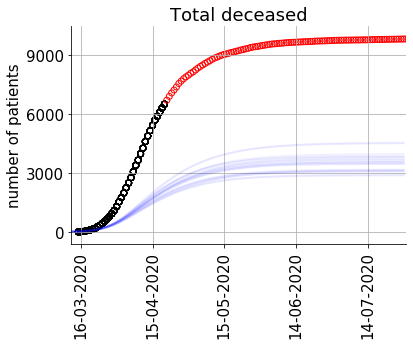

In [19]:
states = [['D']]
data_deceases =[df_sciensano["D_cumsum"].values[:37]]
T = 100 # extra days to plot model for
end_data = 149#52 end of data tranch to plot
start_date = '15-03-2020'
fig,ax=plt.subplots()
for i in range(20):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time], 
          'Nc':      [prevention*(1.00*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)]
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data_deceases,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=df_sciensano["D_cumsum"][37:end_data].size)+datetime.timedelta(days=data[0].size),df_sciensano["D_cumsum"][37:end_data], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1a,1))
#ax.set_ylim([0,850])
plt.title('Total deceased')
#plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

In [21]:
nonpublic_ts = pd.read_csv('../../data/interim/non_public/all_nonpublic_timeseries.csv', parse_dates=['DATE'])
deceased_hosp = nonpublic_ts[['DATE','deceased_hosp']].groupby('DATE').sum()['2020-03-15':].reset_index()
deceased_hosp['cumsum'] = deceased_hosp.deceased_hosp.cumsum()

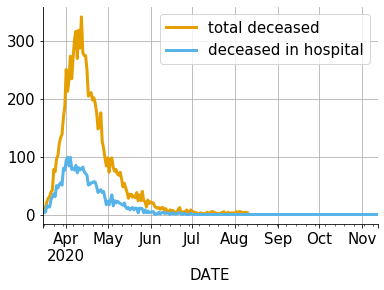

In [25]:
fig,ax = plt.subplots()
df_sciensano.reset_index().plot('DATE','D_tot', ax=ax, label="total deceased")
deceased_hosp.plot('DATE','deceased_hosp', ax=ax, label='deceased in hospital')


<IPython.core.display.Javascript object>


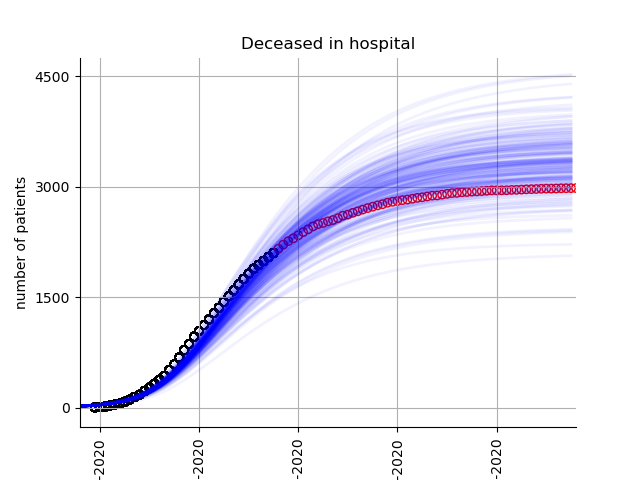

Text(0.5, 1.0, 'Deceased in hospital')

In [29]:
states = [['D']]
plot_data = deceased_hosp["cumsum"]
data_deceased =[plot_data.values[:37]]
T = 60 # extra days to plot model for
end_data = 100#52 end of data tranch to plot
start_date = '15-03-2020'
fig,ax=plt.subplots()
for i in range(200):
    idx,model.parameters['beta'] = random.choice(list(enumerate(samples_dict['beta'])))
    idx,model.parameters['l'] = random.choice(list(enumerate(samples_dict['l'])))
    model.parameters['tau'] = samples_dict['tau'][idx]
    prevention = samples_dict['prevention'][idx]
    # Create a dictionary of past policies
    chk = {'time':   [lag_time], 
          'Nc':      [prevention*(1.00*Nc_home + (1-0.60)*Nc_work + (1-0.70)*Nc_transport + (1-0.30)*Nc_others + (1-0.80)*Nc_leisure)]
          }
    y_model = model.sim(data[0].size+lag_time-1+T,checkpoints=chk)
    ax = plot_fit(y_model,data_deceased,start_date,lag_time,states,T=T,ax=ax,plt_kwargs={'color':'blue','linewidth': 2,'alpha': 0.05})

plt.scatter(pd.date_range('15-03-2020',freq='D',periods=plot_data[37:end_data].size)+datetime.timedelta(days=data[0].size),plot_data[37:end_data], marker='o',color='red',linestyle='None',facecolors='none')
legend_text=['daily \nhospitalizations']
#leg=ax.legend(legend_text, loc="upper left", bbox_to_anchor=(1a,1))
#ax.set_ylim([0,850])
plt.title('Deceased in hospital')
#plt.savefig('plot_fit_compliance.pdf', dpi=600, bbox_inches='tight',orientation='portrait', papertype='a4')

In [34]:
y_model

<xarray.Dataset>
Dimensions:         (stratification: 9, time: 150)
Coordinates:
  * stratification  (stratification) int64 0 1 2 3 4 5 6 7 8
  * time            (time) int64 0 1 2 3 4 5 6 7 ... 143 144 145 146 147 148 149
Data variables:
    S               (stratification, time) float64 1.305e+06 ... 6.234e+05
    E               (stratification, time) float64 1.0 0.7606 ... 8.784 8.164
    I               (stratification, time) float64 0.0 0.2113 ... 6.432 5.978
    A               (stratification, time) float64 0.0 0.04071 ... 14.29 13.28
    M               (stratification, time) float64 0.0 0.01663 ... 33.01 30.69
    ER              (stratification, time) float64 0.0 7.295e-07 ... 4.228 3.931
    C               (stratification, time) float64 0.0 6.763e-08 ... 19.83 18.45
    C_icurec        (stratification, time) float64 0.0 0.0 0.0 ... 5.678 5.366
    ICU             (stratification, time) float64 0.0 0.0 0.0 ... 13.2 12.44
    R               (stratification, time) float64 0.0 0.002951 ... 3.252e+04
    D               (stratification, time) float64 0.0 0.0 ... 2.698e+03
    SQ              (stratification, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    EQ              (stratification, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    IQ              (stratification, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    AQ              (stratification, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    MQ              (stratification, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    RQ              (stratification, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    H_in            (stratification, time) float64 0.0 6.268e-07 ... 1.296 1.204
    H_out           (stratification, time) float64 0.0 1.512e-09 ... 4.322 4.041
    H_tot           (stratification, time) float64 0.0 7.971e-07 ... 42.93 40.19
Attributes:
    parameters:  {'beta': 0.03735323955503414, 'sigma': 3.2, 'omega': 2.0, 'z...

In [36]:
nonpublic_ts

,Unnamed: 0,Arrondissement,Province,NIS,inhabitants,DATE,confirmed_cases,tested_cases,confirmed_per_tested_5days_window,hospitalised_IN,recovered,deceased_hosp,ICU,confirmed_cases_per_100k,hospitalised_IN_per_100k,recovered_per_100k,deceased_hosp_per_100k,ICU_per_100k
0,52,Antwerpen,Antwerpen,11000,1057736.0,2020-01-03,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
1,53,Antwerpen,Antwerpen,11000,1057736.0,2020-01-04,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
2,54,Antwerpen,Antwerpen,11000,1057736.0,2020-01-05,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
3,55,Antwerpen,Antwerpen,11000,1057736.0,2020-01-06,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
4,56,Antwerpen,Antwerpen,11000,1057736.0,2020-01-07,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.094542,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8941,11125,Philippeville,Namen,93000,66315.0,2020-08-01,0.0,89.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
8942,11126,Philippeville,Namen,93000,66315.0,2020-08-02,0.0,26.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN
8943,11127,Philippeville,Namen,93000,66315.0,2020-08-03,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8944,11128,Philippeville,Namen,93000,66315.0,2020-08-28,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
